In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [ ]:
dataset = '../keypoint_training.csv'
model_save_path = '../keypoint_classifier.hdf5'
tflite_save_path = '../keypoint_classifier.tflite'

In [ ]:
NUM_CLASSES = 4

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 4)                 44        
                                                                 
Total params: 1114 (4.35 KB)
Trainable params: 1114 (4.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
19/24 [======================>.......] - ETA: 0s - loss: 0.0228 - accuracy: 0.9926
Epoch 1: saving model to /content/keypoint_classifier.hdf5
24/24 [==============================] - 1s 14ms/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.0109 - val_accuracy: 0.9990
Epoch 2/1000
20/24 [========================>.....] - ETA: 0s - loss: 0.0197 - accuracy: 0.9945
Epoch 2: saving model to /content/keypoint_classifier.hdf5
24/24 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0110 - val_accuracy: 0.9990
Epoch 3/1000
17/24 [====================>.........] - ETA: 0s - loss: 0.0173 - accuracy: 0.9949
Epoch 3: saving model to /content/keypoint_classifier.hdf5
24/24 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0109 - val_accuracy: 0.9990
Epoch 4/1000
17/24 [====================>.........] - ETA: 0s - loss: 0.0209 - accuracy: 0.9926
Epoch 4: saving model to /content/keypoint_classifi

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.9990


In [ ]:
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 66ms/step
[2.0917421e-10 4.7683577e-07 9.9999952e-01 1.7317996e-08]
2


32/32 [==============================] - 0s 2ms/step


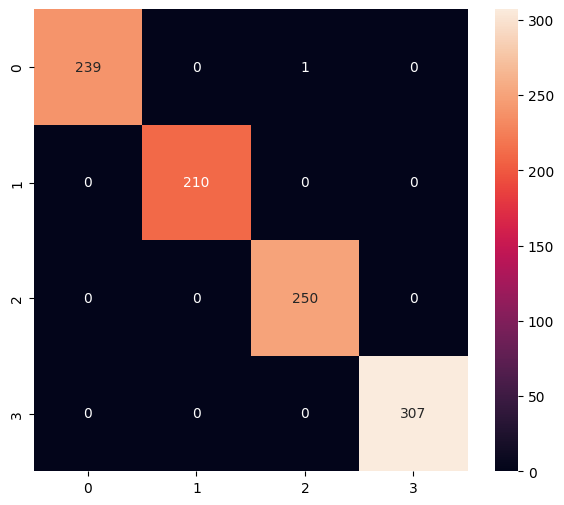

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       250
           3       1.00      1.00      1.00       307

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6596

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 532 µs, sys: 37 µs, total: 569 µs
Wall time: 499 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.0917379e-10 4.7683486e-07 9.9999952e-01 1.7317962e-08]
2
